# A Predictive Analysis of Restaurant Reviews through Classification Modeling

In [1]:
#pip install selenium 

In [2]:
#!pip install selenium
#import sys
#!{sys.executable} -m pip install selenium

In [3]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [81]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import json

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys


import requests
import pandas as pd
import numpy as np
import json
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys

from collections import Counter
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [5]:
# Function to Scrape Yelp Reviews

def scrape_yelp_pages(url):
    # Set up Chrome driver service
    service = webdriver.chrome.service.Service('chromedriver')  
    service.start()

    # Set up Chrome options
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')  

    # Create a new instance of the Chrome driver
    driver = webdriver.Chrome(service=service, options=options)

    # Navigate to the webpage
    driver.get(url)

    # Wait for the page to load and for the first page number element to be visible
    page_number_element = WebDriverWait(driver, 10).until(
        EC.visibility_of_element_located((By.XPATH, '//div[@aria-label="Page: 1"]'))
    )

    reviews = []
    star_ratings = []
    dates = []
    while True:
        # Process the current page here
        review_elements = driver.find_elements(By.XPATH, '//span[@class=" raw__09f24__T4Ezm" and @lang="en"]')
        star_rating_elements = driver.find_elements(By.XPATH, '//div[contains(@aria-label, "star rating")]')
        date_elements = driver.find_elements(By.XPATH, '//span[@class=" css-chan6m"]')

        for review_element, star_rating_element, date_element in zip(review_elements, star_rating_elements, date_elements):
            review_text = review_element.text
            star_rating = star_rating_element.get_attribute('aria-label')
            date = date_element.text

            # Ignore dates with the words 'Photos', 'years', 'Photo', and 'year'
            if 'Photos' not in date and 'years' not in date and 'Photo' not in date and 'year' not in date:
                reviews.append(review_text)
                star_ratings.append(star_rating)
                dates.append(date)

        try:
            # Click on the next page
            next_page_arrow = driver.find_element(By.XPATH, '//span[@class="icon--24-chevron-right-v2 navigation-button-icon__09f24__Bmrde css-1kq79li"]')
            next_page_arrow.click()

            # Wait for a brief moment for the new review elements to load
            WebDriverWait(driver, 1).until(EC.presence_of_element_located((By.XPATH, '//span[@class=" raw__09f24__T4Ezm" and @lang="en"]')))

        except:
            # Break the loop when there are no more pages to click
            break
 # Close the browser window
    driver.quit()

    # Create a DataFrame with the scraped data
    data = pd.DataFrame({'Date': dates, 'Review': reviews, 'Star Rating': star_ratings})

    return data

In [6]:
# Filippi's Pizza

pizza_df = scrape_yelp_pages('https://www.yelp.com/biz/filippis-pizza-grotto-mission-valley-san-diego?osq=pizza')

pizza_df.head()

,Date,Review,Star Rating
0,1/19/2023,We loved every meal we have ever tried at Fili...,5 star rating
1,1/18/2023,I ordered a basil and cheese pizza and it is p...,1 star rating
2,6/4/2023,"This is my Kids FAV pizza in town. Yes, it may...",5 star rating
3,6/6/2023,You've never had a good pizza till you've had ...,5 star rating
4,10/27/2022,"Fast service, Eddie was very efficient and kin...",5 star rating


In [7]:
# To CSV

csv_file_path = 'filippi.csv'

pizza_df.to_csv(csv_file_path, index=False)

In [8]:
# Tacos El G

taco_df = scrape_yelp_pages('https://www.yelp.com/biz/tacos-el-g-national-city-7?osq=Tacos')

taco_df.head()


,Date,Review,Star Rating
0,5/2/2023,Not good there is this weird tasting sauce the...,5 star rating
1,3/14/2023,It really could have been better because I am ...,4 star rating
2,2/19/2023,Tacos are good.\nPrices were raised though so ...,1 star rating
3,4/7/2023,"tacos had no flavor,meat was greasy and tough....",5 star rating
4,3/13/2022,Late night stop with my cousin! Neither of us ...,5 star rating


In [9]:
taco_df.shape

(474, 3)

In [10]:
# To CSV

csv_file_path = 'taco_el_g.csv'

taco_df.to_csv(csv_file_path, index=False)

Part 2: Preprocessing & Exploratory Data Analysis

In [11]:
# accessing the data 
pizza_df = pd.read_csv('filippi_1.csv')
taco_df = pd.read_csv('taco_el_g_1.csv')

In [12]:
# doubling checking that data was pulled correctly 
print("Shape of Pizza Data: ", pizza_df.shape)
print("Shape of Taco Data: ", taco_df.shape)

Shape of Pizza Data:  (239, 3)
Shape of Taco Data:  (546, 3)


In [13]:
# checking for null values 
print("Null Values Present in Pizza Data: ")
pizza_df.isnull().sum()

Null Values Present in Pizza Data: 


Date           0
Review         0
Star_Rating    0
dtype: int64

In [14]:
print("Null Values Present in Taco Data: ")
taco_df.isnull().sum()

Null Values Present in Taco Data: 


Date           0
Review         0
Star_Rating    0
dtype: int64

In [15]:
# checking datatype for each of the variables within the data 
print("Datatypes Present in Pizza Data: ")
pizza_df.dtypes

Datatypes Present in Pizza Data: 


Date           object
Review         object
Star_Rating    object
dtype: object

In [16]:
print("Datatypes Present in Taco Data: ")
taco_df.dtypes

Datatypes Present in Taco Data: 


Date           object
Review         object
Star_Rating    object
dtype: object

In [17]:
#renaming columns
pizza_df.rename(columns = {'Star Rating':'Star_Rating'}, inplace = True)
taco_df.rename(columns = {'Star Rating':'Star_Rating'}, inplace = True)

In [18]:
# fixing the formatting in the "Star_Rating" column for pizza df  
pizza_df['Star_Rating'] = pizza_df.Star_Rating.str.extract('(\d+)')

# checking 
pizza_df.head(3)

,Date,Review,Star_Rating
0,1/19/23,You've never had a good pizza till you've had ...,5
1,1/18/23,"This is my Kids FAV pizza in town. Yes, it may...",1
2,12/4/22,I ordered a basil and cheese pizza and it is p...,5


In [19]:
# fixing the formatting in the "Star_Rating" column for taco df  
taco_df['Star_Rating'] = taco_df.Star_Rating.str.extract('(\d+)')

# checking 
taco_df.head(3)

,Date,Review,Star_Rating
0,5/2/23,It really could have been better because I am ...,4
1,3/14/23,Tacos are good.\nPrices were raised though so ...,1
2,2/19/23,Late night stop with my cousin! Neither of us ...,5


In [20]:
# adding the resturant name to each dataset -> ease of differentiation when combining later 
pizza_df['Restaurant'] = "pizza"
taco_df['Restaurant'] = "taco"

# checking 
display(pizza_df.head(3), taco_df.head(3))

,Date,Review,Star_Rating,Restaurant
0,1/19/23,You've never had a good pizza till you've had ...,5,pizza
1,1/18/23,"This is my Kids FAV pizza in town. Yes, it may...",1,pizza
2,12/4/22,I ordered a basil and cheese pizza and it is p...,5,pizza


,Date,Review,Star_Rating,Restaurant
0,5/2/23,It really could have been better because I am ...,4,taco
1,3/14/23,Tacos are good.\nPrices were raised though so ...,1,taco
2,2/19/23,Late night stop with my cousin! Neither of us ...,5,taco


In [21]:
# merging the dataframes 
pt_df = pd.concat([pizza_df, taco_df],    # Combine vertically
                          ignore_index = True,
                          sort = False)

# checking that nothing was lost -> total should be 785 (Pizza = 239 + Tacos = 546)
print("Shape of Combined Data: ", pt_df.shape)

Shape of Combined Data:  (785, 4)


In [22]:
# changing star_rating to int otherwise will obtain the following error for the next step: 
# TypeError: '>=' not supported between instances of 'str' and 'int'
pt_df['Star_Rating'] = pt_df['Star_Rating'].astype(str).astype(int)

# adding a customer sentiment towards to resturant based on the star rating recieved 
pt_df['Customer_Sentiment'] = np.where(pt_df['Star_Rating'] >= 3, 'positive', 'negative')

# checking 
pt_df.head(3)

,Date,Review,Star_Rating,Restaurant,Customer_Sentiment
0,1/19/23,You've never had a good pizza till you've had ...,5,pizza,positive
1,1/18/23,"This is my Kids FAV pizza in town. Yes, it may...",1,pizza,negative
2,12/4/22,I ordered a basil and cheese pizza and it is p...,5,pizza,positive


In [23]:
# reorganizing column order for ease of use 
pt_df = pt_df.reindex(columns=['Date', 'Star_Rating', 'Restaurant', 
                               'Customer_Sentiment', 'Review'])

# checking 
pt_df.head(1)

,Date,Star_Rating,Restaurant,Customer_Sentiment,Review
0,1/19/23,5,pizza,positive,You've never had a good pizza till you've had ...


In [24]:
# cleaning/tokenizing/normalizing/pattern functions: 

# punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# stopwords
sw = stopwords.words("english")
# sw.extend(["tacos"])

# helper functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    num_tokens = len(tokens) 
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens / num_tokens
    num_characters = sum(len(i) for i in tokens)
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
        print("The top 5 most common tokens")
        print(Counter(tokens).most_common(5))
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])

def remove_stop(tokens) :
    return[i for i in tokens if i.lower() not in sw]

def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))
def tokenize(text) : 
    text = text.split()
    return(text)

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

# cleaning pipeline: case folding, fixing punctuation, tokenizing, and removing stopwords 
clean_pipe = [str.lower, remove_punctuation, tokenize, remove_stop]

In [25]:
# applying pipeline
pt_df["tokens"] = pt_df["Review"].apply(prepare,pipeline=clean_pipe)
pt_df["num_tokens"] = pt_df["tokens"].map(len) 

# using textblot to calculate sentiment polarity [-1, 1]: 1=+, -1=-, 0=neutral
pt_df['polarity'] = pt_df['Review'].map(lambda text: TextBlob(text).sentiment.polarity)

# check 
pt_df.head(5)

,Date,Star_Rating,Restaurant,Customer_Sentiment,Review,tokens,num_tokens,polarity
0,1/19/23,5,pizza,positive,You've never had a good pizza till you've had ...,"[youve, never, good, pizza, till, youve, pizza...",17,0.477778
1,1/18/23,1,pizza,negative,"This is my Kids FAV pizza in town. Yes, it may...","[kids, fav, pizza, town, yes, may, 2x, 3x, cos...",55,0.013636
2,12/4/22,5,pizza,positive,I ordered a basil and cheese pizza and it is p...,"[ordered, basil, cheese, pizza, phenomenal, ch...",34,0.600000
3,8/26/16,5,pizza,positive,"Myself, and my dear Friend and her daughter vi...","[dear, friend, daughter, visited, may, 13, lat...",53,-0.059167
4,2/13/15,4,pizza,positive,Me and my co-workers went to this location for...,"[coworkers, went, location, first, time, picke...",29,-0.069444


In [26]:
# Looking at the Reviews associated with Positive Sentiment 
print('5 random Reviews with the Highest Positive Sentiment Polarity: \n')
cl = pt_df.loc[pt_df.polarity == 1, ['Review']].sample(5).values
for c in cl:
    print(c[0])

5 random Reviews with the Highest Positive Sentiment Polarity: 

As legit as there locations in BC, it's the best taco shop in town.
best. tacos. i've. ever. eaten.

ever.

holygod.

______________________ This is me speechless.
Off the damn chain. Amazing place. !!!!   !!!      !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!     !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Tacos de Adobado are delicious, also recommend their quesadillas.
Oh my god!!!

Best Tacos in all San DIego.

This is a must go!


In [27]:
# Looking at the Reviews associated with Neutral Sentiment 
print('5 random Reviews with the Highest Neutral Sentiment Polarity: \n')
cl = pt_df.loc[pt_df.polarity == 0, ['Review']].sample(5).values
for c in cl:
    print(c[0])

5 random Reviews with the Highest Neutral Sentiment Polarity: 

At the peak of a global pandemic, this guy has the guts to prepare food with no face covering. I'm hungry but not that hungry.
I went with my family to eat at this place.
The cashier make us have an embarrassing moment when she tried to charge us twice the food, we had to find the tickets and show them to her, then she went to our table and count everithing again
After all the show she did, she didn't apologize
We feel everybody was looking at us
Salí de trabajar cansado y con hambre ordene y todo bien y luego fui a ordenar la comida y recibieron mi ticket esperando mi comida pasaron 20 minutos y nunca me hicieron mi comida, siempre vengo aquí y es la primera vez que el servicio está pa la chingada no se que estaba pasando pero no modo voy para otro lado para taco Tuesday
I'm not a big fan of Mexican food, but I'd drive 100 miles south for some Adobada tacos from Tacos El Gordo! That's all I can say.
On sat 1-25-2014 just 

In [28]:
# Looking at the Reviews associated with Negative Sentiment 
print('5 random Reviews with the Highest Negative Sentiment Polarity: \n')
cl = pt_df.loc[pt_df.polarity == -0.3, ['Review']].sample(5).values
for c in cl:
    print(c[0])

5 random Reviews with the Highest Negative Sentiment Polarity: 

Waited 30 minutes in line to find out your ATM machine was offline and not working. Didn't have cash on me. The LEAST you guys could've done was given me my order for free considering you had already started making it. 2 mulas. Damn. Y'all sell a billion tacos per week. STINGY. And that rule of not taking order until you get to the window - the WORST. Canceled for me.
Horrible service!!! I guess this place is not a tacos el gordo location anymore... I ordered to go. They made me wait forever to get four tacos. I was not given lemons or radishes with my order. I went inside and the lady said that they only provide with lemons and radishes if I request them. Really?? How am I supposed to know that?? It is a to go order lady... what about asking customers or posting a sign by the drive through window...no common sense. the lady never apologize for the bad service. I'm never coming back!
Stood there for twenty minutes and cou

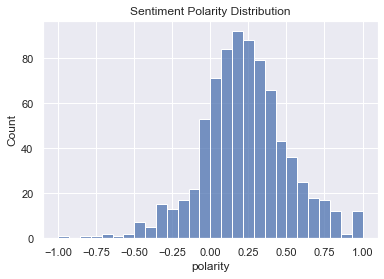

In [29]:
# distribution of polarity 
sns.set(style="darkgrid")
sns.histplot(data=pt_df, x="polarity").set(title='Sentiment Polarity Distribution')
plt.show()

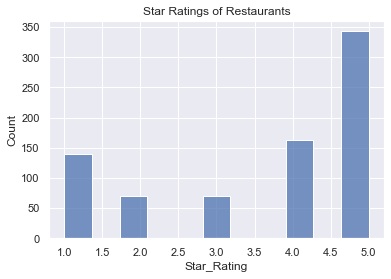

In [30]:
# distribution of star_rating 
sns.set(style="darkgrid")
sns.histplot(data=pt_df, x="Star_Rating").set(title='Star Ratings of Restaurants')
plt.show()

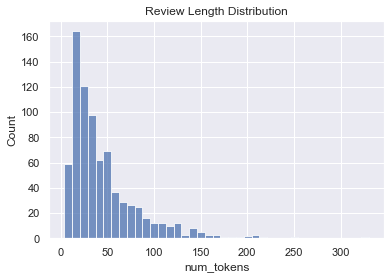

In [31]:
# distribution of review text lengths 
sns.set(style="darkgrid")
sns.histplot(data=pt_df, x="num_tokens").set(title='Review Length Distribution')
plt.show()

Customer_Sentiment
negative    AxesSubplot(0.125,0.125;0.775x0.755)
positive    AxesSubplot(0.125,0.125;0.775x0.755)
Name: num_tokens, dtype: object

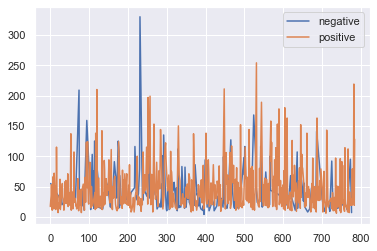

In [32]:
# distribution of review word count 
pt_df.groupby('Customer_Sentiment')['num_tokens'].plot(legend=True)

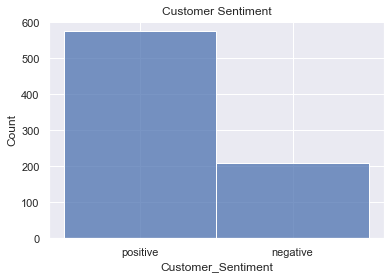

In [33]:
# distribution of positive vs negative reviews 
sns.set(style="darkgrid")
sns.histplot(data=pt_df, x="Customer_Sentiment").set(title='Customer Sentiment')
plt.show()

In [34]:
# descriptive stats for positive vs negative reviews 

# defining a fxn to pull the descriptive stats 
def f_descriptive_stats(li):
    w_l = [i for s in li for i in s]
    return descriptive_stats(w_l)

# descriptive stats for positive reviews
print("\n Descriptive Stats: Positive Reviews \n")
f_descriptive_stats(pt_df[pt_df['Customer_Sentiment']=='positive']['tokens'])

# descriptive stats for negative reviews 
print("\n Descriptive Stats: Negative Reviews \n")
f_descriptive_stats(pt_df[pt_df['Customer_Sentiment']=='negative']['tokens'])


 Descriptive Stats: Positive Reviews 

There are 26457 tokens in the data.
There are 4111 unique tokens in the data.
There are 140675 characters in the data.
The lexical diversity is 0.155 in the data.
The top 5 most common tokens
[('tacos', 813), ('food', 297), ('good', 286), ('place', 281), ('taco', 255)]

 Descriptive Stats: Negative Reviews 

There are 9503 tokens in the data.
There are 2434 unique tokens in the data.
There are 50865 characters in the data.
The lexical diversity is 0.256 in the data.
The top 5 most common tokens
[('tacos', 250), ('place', 114), ('food', 106), ('good', 99), ('get', 78)]


[9503, 2434, 0.25612964327054616, 50865]

In [35]:
# wordcloud function obtained from Blueprints for Text Analytics Using Python textbook
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [36]:
# positive reviews wordcloud
positive_lcount = count_words(pt_df[pt_df['Customer_Sentiment']=='positive'])
print('WORDCLOUD FOR POSITIVE REVIEWS')
wordcloud(positive_lcount.squeeze())

WORDCLOUD FOR POSITIVE REVIEWS


AttributeError: 'TransposedFont' object has no attribute 'getbbox'

In [ ]:
# negative reviews wordcloud
neg_lcount = count_words(pt_df[pt_df['Customer_Sentiment']=='negative'])
print('WORDCLOUD FOR NEGATIVE REVIEWS')
wordcloud(neg_lcount.squeeze())

# Part 3: Modeling & Model Evaluations

In [37]:
# final dataframe = pt_df
pt_df.head()

,Date,Star_Rating,Restaurant,Customer_Sentiment,Review,tokens,num_tokens,polarity
0,1/19/23,5,pizza,positive,You've never had a good pizza till you've had ...,"[youve, never, good, pizza, till, youve, pizza...",17,0.477778
1,1/18/23,1,pizza,negative,"This is my Kids FAV pizza in town. Yes, it may...","[kids, fav, pizza, town, yes, may, 2x, 3x, cos...",55,0.013636
2,12/4/22,5,pizza,positive,I ordered a basil and cheese pizza and it is p...,"[ordered, basil, cheese, pizza, phenomenal, ch...",34,0.600000
3,8/26/16,5,pizza,positive,"Myself, and my dear Friend and her daughter vi...","[dear, friend, daughter, visited, may, 13, lat...",53,-0.059167
4,2/13/15,4,pizza,positive,Me and my co-workers went to this location for...,"[coworkers, went, location, first, time, picke...",29,-0.069444


In [38]:
pt_df.shape

(785, 8)

# Splitting the data into trainig and testing

In [39]:
# Splitting the data
x_train, x_test, y_train, y_test = train_test_split(pt_df['tokens'],
                                                    pt_df['Customer_Sentiment'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=pt_df["Customer_Sentiment"])

In [40]:
print('Size of Training Data ', x_train.shape[0])
print('Size of Test Data ', x_test.shape[0])

Size of Training Data  628
Size of Test Data  157


In [41]:
# We're going to use a TfidfVectorizer to convert tokens lists to numbers

X_train = x_train.astype(str)
X_test = x_test.astype(str)

tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")

X_train_tf = tfidf.fit_transform(X_train).toarray()
X_test_tf = tfidf.transform(X_test).toarray()

# Unbalanced Class

<AxesSubplot:>

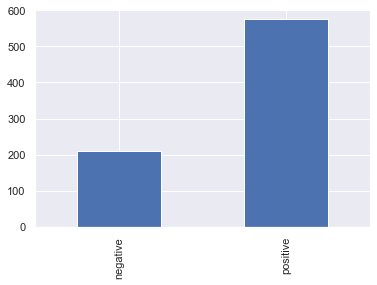

In [42]:
#Imbalance class
pt_df['Customer_Sentiment'].value_counts().sort_index().plot(kind='bar')

In [43]:
#Dummy Classifier (Baseline Model)
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train_tf, y_train)

# Predicting on the test data
y_pred = dummy_clf.predict(X_test_tf)
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         0
    positive       1.00      0.73      0.85       157

    accuracy                           0.73       157
   macro avg       0.50      0.37      0.42       157
weighted avg       1.00      0.73      0.85       157



In [44]:
# K-Nearest Neighbor (KNN)  Model 
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_tf, y_train)
# KNN Model Prediction on Validation Set 
knn_pred = knn.predict(X_test_tf)
# KNN Model Evals - Confusion Matrix 
print(accuracy_score(y_test, knn_pred))
print('Classification Report \n', 
       classification_report(y_test, knn_pred))

0.6878980891719745
Classification Report 
               precision    recall  f1-score   support

    negative       0.32      0.14      0.20        42
    positive       0.74      0.89      0.81       115

    accuracy                           0.69       157
   macro avg       0.53      0.51      0.50       157
weighted avg       0.63      0.69      0.64       157



In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics 
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train_tf, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test_tf)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print('Accuracy Score - ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6624203821656051
Accuracy Score -  0.6624203821656051
              precision    recall  f1-score   support

    negative       0.33      0.26      0.29        42
    positive       0.75      0.81      0.78       115

    accuracy                           0.66       157
   macro avg       0.54      0.54      0.54       157
weighted avg       0.64      0.66      0.65       157



In [46]:
#  Random Forest Classifier
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_train_tf, y_train)

# Predicting on the test data
y_pred = classifier.predict(X_test_tf)
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

    negative       0.07      1.00      0.13         3
    positive       1.00      0.75      0.86       154

    accuracy                           0.75       157
   macro avg       0.54      0.87      0.49       157
weighted avg       0.98      0.75      0.84       157



In [47]:
#LinearSVC
model1 = LinearSVC(random_state = 0, tol =1e-5)
model1.fit(X_train_tf, y_train)

#Prediction
y_pred = model1.predict(X_test_tf)
print('Accuracy Score - ', accuracy_score(y_test, y_pred))

#Confusion matrix
confusion_matrix(y_test, y_pred)

#Classification report
print(classification_report(y_test, y_pred))

Accuracy Score -  0.732484076433121
              precision    recall  f1-score   support

    negative       0.50      0.29      0.36        42
    positive       0.77      0.90      0.83       115

    accuracy                           0.73       157
   macro avg       0.64      0.59      0.60       157
weighted avg       0.70      0.73      0.71       157



In [48]:
#SUPPORT VECTOR MACHINE (SVM)
from sklearn import svm
from sklearn.svm import SVC

cls = svm.SVC(kernel="linear", gamma="auto", C=2)


cls.fit(X_train_tf, y_train)
y_predict = cls.predict(X_test_tf)

print('Accuracy Score:', accuracy_score(y_test, y_predict))
print('\n')
print(classification_report(y_test, y_predict))

Accuracy Score: 0.7261146496815286


              precision    recall  f1-score   support

    negative       0.47      0.17      0.25        42
    positive       0.75      0.93      0.83       115

    accuracy                           0.73       157
   macro avg       0.61      0.55      0.54       157
weighted avg       0.68      0.73      0.68       157



# Balanced Class

In [50]:
# SMOTE over sampling 
#resampling rarely works well with text data
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 42)
X_train_res, y_train_res = sm.fit_sample(X_train_tf, y_train)

print("Number of X_train before and after resampling: ", X_train_tf.shape, X_train_res.shape)
print("Number of y_train after resampling: ", y_train.shape, y_train_res.shape)
print("Number of X_test after resampling: ", X_test_tf.shape,X_test_tf.shape)
print("Number of y_test after resampling: ", y_test.shape,y_test.shape)

Number of X_train before and after resampling:  (628, 480) (920, 480)
Number of y_train after resampling:  (628,) (920,)
Number of X_test after resampling:  (157, 480) (157, 480)
Number of y_test after resampling:  (157,) (157,)


              precision    recall  f1-score   support

    negative       1.00      0.27      0.42       157
    positive       0.00      0.00      0.00         0

    accuracy                           0.27       157
   macro avg       0.50      0.13      0.21       157
weighted avg       1.00      0.27      0.42       157



<AxesSubplot:>

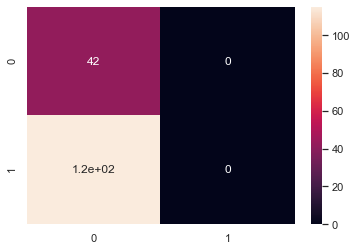

In [74]:
#Dummy Classifier (Baseline Model)
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train_res, y_train_res)

# Predicting on the test data
Dummy_pred = dummy_clf.predict(X_test_tf)
cm = confusion_matrix(y_test, Dummy_pred)
print(classification_report(Dummy_pred, y_test))
sns.heatmap(cm, annot=True)

              precision    recall  f1-score   support

    negative       0.12      0.36      0.18        14
    positive       0.92      0.74      0.82       143

    accuracy                           0.71       157
   macro avg       0.52      0.55      0.50       157
weighted avg       0.85      0.71      0.76       157



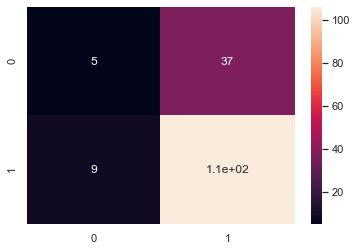

In [76]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf.fit(X_train_res, y_train_res)

# Predicting on the test data
rf_pred = rf.predict(X_test_tf)

# Confusion matrix
cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm, annot=True)

# Classification report
print(classification_report(rf_pred, y_test))

Accuracy Score -  0.6242038216560509
              precision    recall  f1-score   support

    negative       0.40      0.33      0.37        51
    positive       0.70      0.76      0.73       106

    accuracy                           0.62       157
   macro avg       0.55      0.55      0.55       157
weighted avg       0.61      0.62      0.61       157



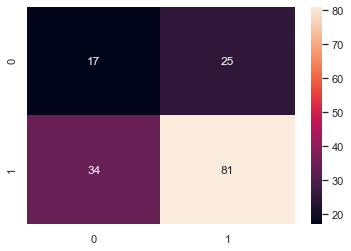

In [77]:
# LinearSVC
lsvc = LinearSVC(random_state = 42, tol =1e-5)
lsvc.fit(X_train_res, y_train_res)

#Prediction
lsvc_pred = lsvc.predict(X_test_tf)

# Confusion matrix
cm = confusion_matrix(y_test, lsvc_pred)
sns.heatmap(cm, annot=True)

print('Accuracy Score - ', accuracy_score(y_test, lsvc_pred))
print(classification_report(lsvc_pred, y_test))

Fitting 10 folds for each of 30 candidates, totalling 300 fits
{'n_neighbors': 1}
Accuracy for our training dataset with tuning is : 57.83%
0.31210191082802546
Classification Report 
               precision    recall  f1-score   support

    negative       0.98      0.28      0.43       148
    positive       0.07      0.89      0.13         9

    accuracy                           0.31       157
   macro avg       0.52      0.58      0.28       157
weighted avg       0.92      0.31      0.41       157



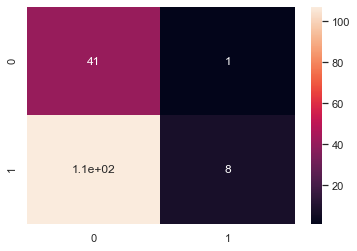

In [78]:
# KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
from sklearn.model_selection import GridSearchCV
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)
  
# defining parameter range
grid = GridSearchCV(knn, param_grid,
                    cv=10,
                    scoring='accuracy',
                    return_train_score=False,
                    verbose=1)
  
# fitting the model for grid search
grid_search=grid.fit(X_train_res, y_train_res)

print(grid_search.best_params_)

accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )




knn = KNeighborsClassifier(n_neighbors=2)

knn.fit(X_train_res, y_train_res)

# KNN Model Prediction on Validation Set 
knn_pred = knn.predict(X_test_tf)

# Confusion matrix
cm = confusion_matrix(y_test, knn_pred)
sns.heatmap(cm, annot=True)

# KNN Model Evals - Confusion Matrix 
print(accuracy_score(y_test, knn_pred))
print('Classification Report \n', 
       classification_report(knn_pred, y_test))

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Accuracy: 0.6114649681528662
Accuracy Score -  0.6114649681528662
              precision    recall  f1-score   support

    negative       0.19      0.23      0.21        35
    positive       0.77      0.72      0.74       122

    accuracy                           0.61       157
   macro avg       0.48      0.47      0.48       157
weighted avg       0.64      0.61      0.62       157



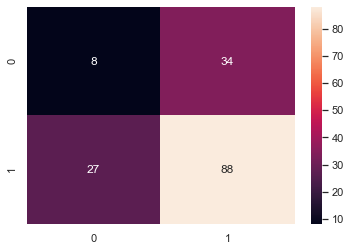

In [79]:
# GridSearchCV for Decision Tree
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as metrics
param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7, 8, 9],
              'criterion' :['gini', 'entropy']
             }
tree_clas = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=tree_clas, param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_train_res, y_train_res)
tree_predict = grid_search.predict(X_test_tf)

# Confusion matrix
cm = confusion_matrix(y_test, tree_predict)
sns.heatmap(cm, annot=True)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, tree_predict))
print('Accuracy Score - ', accuracy_score(y_test, tree_predict))
print(classification_report(tree_predict, y_test))

Model accuracy score: 0.6115
              precision    recall  f1-score   support

    negative       0.48      0.34      0.40        59
    positive       0.66      0.78      0.71        98

    accuracy                           0.61       157
   macro avg       0.57      0.56      0.55       157
weighted avg       0.59      0.61      0.59       157



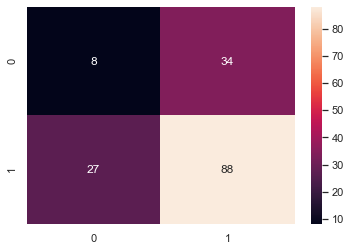

In [80]:
#Naive Bayes

from sklearn.naive_bayes import GaussianNB
# instantiate the model
gnb = GaussianNB()

gnb.fit(X_train_res, y_train_res)
y_pred = gnb.predict(X_test_tf)

# Confusion matrix
cm = confusion_matrix(y_test, tree_predict)
sns.heatmap(cm, annot=True)

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
print(classification_report(y_pred, y_test))

In [ ]:
# 
runSUV = True

tfidf = TfidfVectorizer(stop_words='english')

if(runSVC):
    model = SVC(random_state = 42, probability = True)
    grid_param = [{
        'tfidf_min_df':[5,10],
        'tfidf_ngram_range':[(1,3),(1,6)],
        'model_c':[1,100],
        'model_kernel':['linear']
        
    }]
else:
    model = LinearSVC(random_state = 42, tol= 1e-5)
    grid_param = {
        'tfidf_min_df':[5,10],
        'tfidf_ngram_range':[(1,3),(1,6)],
        'model_c':[1,100],
        'model_loss':['hinge']
        
    }

training_pipeline = pipeline(
    steps = [('tfidf',TfidfVectorizer(stop_words='english')),('model',model)])

gridSearchProcessor = GridSearchCV(estimator = training_pipeline,
                                  param_grid = grid_param,
                                  cv = 5)
gridSearchProcessor.fit(X_res, y_res)

best_params = gridSearchProcessor.best_params_
print('Best alpha parameter identified by grid search', best_params)

best_result = gridSearchProcessor.best_score_
print('Best result identified by grid search', best_result_)

best_model = gridSearchProcessor.best_estimator_


#Model Evaluation
y_pred = best_model.predict(X_test_tf)
print('Accuracy Score - ', accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
    


# Model comparision

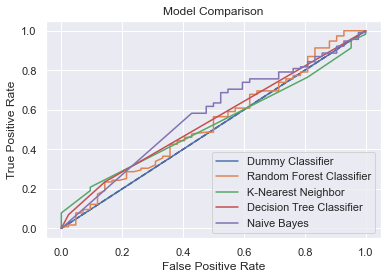

In [73]:
#ROC Curve
# Dummy Classifier, Random Forest Classifier, KNN,Naive Bayes, and Decision Tree Classifier Model Comparisons 
from sklearn.metrics import roc_curve

y_pred_prob1 = dummy_clf.predict_proba(X_test_tf)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_pred_prob1, pos_label='positive')

y_pred_prob2 = rf.predict_proba(X_test_tf)[:,1]
fpr2 , tpr2, thresholds2 = roc_curve(y_test, y_pred_prob2, pos_label='positive')


y_pred_prob3 = grid_search.predict_proba(X_test_tf)[:,1]
fpr3 , tpr3, thresholds3 = roc_curve(y_test, y_pred_prob3, pos_label='positive')

y_pred_prob4 = knn.predict_proba(X_test_tf)[:,1]
fpr4 , tpr4, thresholds4 = roc_curve(y_test, y_pred_prob4, pos_label='positive')

y_pred_prob5 = gnb.predict_proba(X_test_tf)[:,1]
fpr5 , tpr5, thresholds5 = roc_curve(y_test, y_pred_prob5, pos_label='positive')


plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "Dummy Classifier")
plt.plot(fpr2, tpr2, label= "Random Forest Classifier")
plt.plot(fpr3, tpr3, label= "K-Nearest Neighbor")
plt.plot(fpr4, tpr4, label= "Decision Tree Classifier")
plt.plot(fpr5, tpr5, label= "Naive Bayes")

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Model Comparison')
plt.show()